In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cmclimate
import os
%matplotlib inline
matplotlib.rcParams['figure.figsize']= (20, 8)
matplotlib.rcParams['xtick.labelsize']= 14
matplotlib.rcParams['ytick.labelsize']= 14
matplotlib.rcParams['axes.labelsize']= 16

In [2]:
%pdb off

Automatic pdb calling has been turned OFF


In [3]:
def add_map(lon_min=-180, lon_max=180, lat_min=-90, lat_max=90,
            central_longitude=0., scale='auto', ax=None):
    """
    Add the map to the existing plot using cartopy

    Parameters
    ----------
    lon_min : float, optional
        Western boundary, default is -180
    lon_max : float, optional
        Eastern boundary, default is 180
    lat_min : float, optional
        Southern boundary, default is -90
    lat_max : float, optional
        Northern boundary, default is 90
    central_longitude : float, optional
        Central longitude, default is 180
    scale : {‘auto’, ‘coarse’, ‘low’, ‘intermediate’, ‘high, ‘full’}, optional
        The map scale, default is 'auto'
    ax : GeoAxes, optional
        A new GeoAxes will be created if None

    Returns
    -------
    ax : GeoAxes
    Return the current GeoAxes instance
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    extent = (lon_min, lon_max, lat_min, lat_max)
    if ax is None:
        ax = plt.subplot(1, 1, 1,
                         projection=ccrs.PlateCarree(
	                                       central_longitude=central_longitude))
    ax.set_extent(extent)
    land = cfeature.GSHHSFeature(scale=scale,
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

In [4]:
def binning_gradients(data, lon_res=0.05, lat_res=0.05, 
                            lon_min=0., lon_max=360., 
                            lat_min=-80., lat_max=80, 
                            min_nobs=100):
    # Define the latitudinal and longitudinal binning
    #lon_bins = np.arange(data['lon'].min().data
    #                     data['lon'].max().data, lon_res)
    lon_bins = np.arange(lon_min, lon_max, lon_res)
    lon_labels = lon_bins[:-1] - np.diff(lon_bins) / 2
    #lat_bins = np.arange(data['lat'].min().data,
    #                     data['lat'].max().data, lat_res)
    lat_bins = np.arange(lat_min, lat_max, lat_res)
    lat_labels = lat_bins[:-1] - np.diff(lat_bins) / 2
    mean_gradients = []
    total_nobs = []
    lat_values = []
    for i, ds in list(data.groupby_bins('lat', lat_bins, 
                                        labels=lat_labels, 
                                        include_lowest=True)):
        try:
            group = ds.groupby_bins('lon', lon_bins, 
                                    labels=lon_labels, 
                                    include_lowest=True)
            bins = group.median().sortby('lon_bins')
            nobs = group.count().sortby('lon_bins')
            mean_gradients.append(bins)
            total_nobs.append(nobs)
            lat_values.append(i)
        except (ValueError, StopIteration):
            dummy_array = xr.DataArray(np.full(len(lon_labels), 
                                               np.nan), 
                                       dims='lon_bins', 
                                       coords={'lon_bins': 
                                               ('lon_bins', lon_labels)
                                              }
                                      )
            mean_gradients.append(dummy_array)
            lat_values.append(i)
    res_bins = (xr.concat(mean_gradients, dim='lat')
                  .assign_coords(lat=lat_values)
                  .rename({'lon_bins': 'lon'})
                  .sortby('lat')
               )
    res_obs = (xr.concat(total_nobs, dim='lat')
                 .assign_coords(lat=lat_values)
                 .rename({'lon_bins': 'lon'})
                 .sortby('lat')
              )
    return xr.Dataset({data.name:res_bins, 'nobs':res_obs})

In [5]:
def plot_and_bin_gradients(ds, var='SSb', lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, vmax=8e-8):    
    from matplotlib.colors import LogNorm 
    binned_buoyancy_gradients = binning_gradients(np.abs(ds[var + '_LS']), lon_res=1, lat_res=1)
    annual_buoyancy_gradients = binned_buoyancy_gradients[var + '_LS'].where(binned_buoyancy_gradients['nobs'] > 50)
    add_map(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, scale='low')
    annual_buoyancy_gradients.plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=vmax)

In [6]:
def plot_and_bin_APE(ds, ds_mld, var='SSb', lon_min=-180, lon_max=180, lat_min=-90, lat_max=90):    
    from matplotlib.colors import LogNorm 
    binned_buoyancy_gradients = binning_gradients(np.abs(ds[var + '_ME']), lon_res=0.5, lat_res=0.5)
    binned_mld = bin_2d_data(ds_mld, lon_res=0.5, lat_res=0.5)
    APE = binned_buoyancy_gradients * binned_mld ** 2
    annual_buoyancy_gradients = binned_buoyancy_gradients[var + '_ME'].where(binned_buoyancy_gradients['nobs'] > 50)
    add_map(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, scale='low')
    APE.plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200)

In [7]:
def compute_annual_cycle(ds, freq='1M'):
    time = pd.date_range("2000-01", "2001", freq=freq)
    an_period = pd.Timedelta(1, unit='Y')
    t = 2 * np.pi * xr.DataArray(pd.to_numeric(time) / an_period.value, dims='time', coords={'time': time})
    mean = ds['mean']
    an_cos = ds['an_cos']
    an_sin = ds['an_sin']
    cycle = mean + an_cos * np.cos(t) + an_sin * np.sin(t)
    return cycle

In [10]:
def get_winter_and_summer_season(ds):
    ds_by_month = dict(ds.groupby('time.month'))
    # Winter is defined as January/February/March
    ds_winter = xr.concat((ds_by_month[1], ds_by_month[2], ds_by_month[3]), dim='time')
    # Summer is defined as July/August/September
    ds_summer = xr.concat((ds_by_month[7], ds_by_month[8], ds_by_month[9]), dim='time')    
    return ds_winter, ds_summer

In [11]:
path = '/data/RESULTS/SURFACE_GRADIENTS_10KM/'

# Gradients from LEGOS TSG dataset

In [17]:
if os.path.isfile(path + 'GLOBAL/TSG_LEGOS_horizontal_gradients.nc'):
    ds_LEGOS = xr.open_dataset(path + 'GLOBAL/TSG_LEGOS_horizontal_gradients.nc', 
                               chunks={'time': 1e7})
else:
    ds_LEGOS = xr.open_mfdataset(path + 'TSG_LEGOS/LEGOS_*_horizontal_gradients.nc', 
                                 concat_dim='time', autoclose=True).load()
    ds_LEGOS.to_netcdf(path + 'GLOBAL/TSG_LEGOS_horizontal_gradients.nc')

In [18]:
ds_LEGOS

<xarray.Dataset>
Dimensions:  (time: 11809908)
Coordinates:
  * time     (time) datetime64[ns] 2008-02-26T04:15:00 2008-02-26T04:19:59 ...
    lon      (time) float32 dask.array<shape=(11809908,), chunksize=(10000000,)>
    lat      (time) float32 dask.array<shape=(11809908,), chunksize=(10000000,)>
Data variables:
    SSb_LS   (time) float64 dask.array<shape=(11809908,), chunksize=(10000000,)>
    SSS_LS   (time) float64 dask.array<shape=(11809908,), chunksize=(10000000,)>
    SST_LS   (time) float64 dask.array<shape=(11809908,), chunksize=(10000000,)>

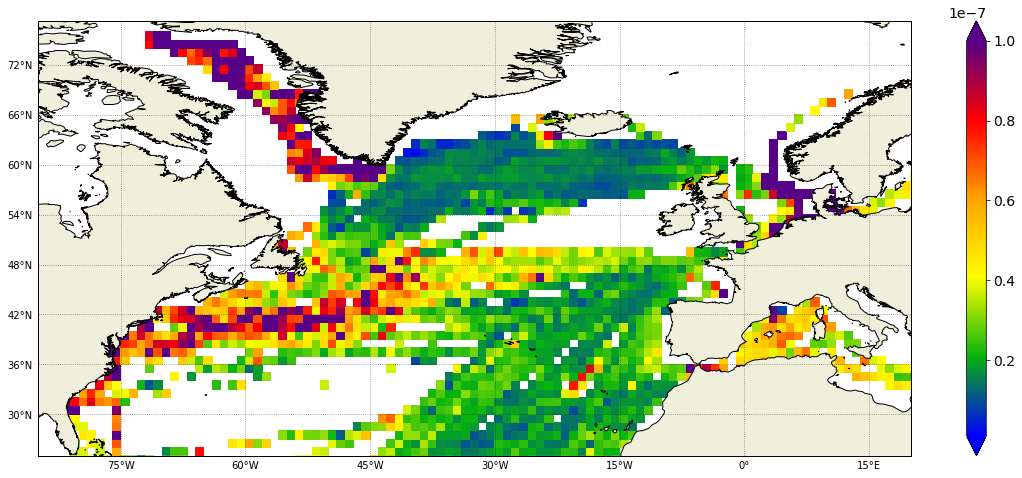

In [20]:
plot_and_bin_gradients(ds_LEGOS,  lon_min=-85, lon_max=20, lat_min=25, lat_max=70, vmax=1e-7)

# Gradients from GOSUD NRT TSG dataset

In [14]:
if os.path.isfile(path + 'GLOBAL/TSG_GOSUD_horizontal_gradients.nc'):
    ds_GOSUD = xr.open_dataset(path + 'GLOBAL/TSG_GOSUD_horizontal_gradients.nc', 
                               chunks={'time': 1e7})  
else:
    ds_GOSUD = xr.open_mfdataset(path + 'TSG_GOSUD/*/*.nc', 
                                 concat_dim='time', autoclose=True).load()
    ds_GOSUD.to_netcdf(path +'GLOBAL/TSG_GOSUD_horizontal_gradients.nc')

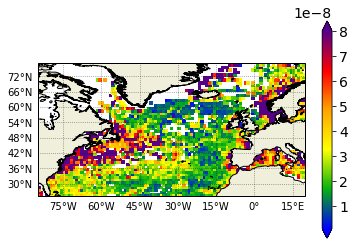

In [15]:
plot_and_bin_gradients(ds_GOSUD, lon_min=-85, lon_max=20, lat_min=25, lat_max=70, vmax=1e-7)

# All dataset combined together

In [13]:
if os.path.isfile(path + 'GLOBAL/ALL_horizontal_gradients.nc'):
    ds_ALL = xr.open_dataset(path + 'GLOBAL/ALL_horizontal_gradients.nc', 
                               chunks={'time': 1e7})
else:
    ds_ALL = xr.concat((ds_LEGOS, ds_GOSUD), dim='time')
    ds_ALL.to_netcdf(path + 'GLOBAL/ALL_horizontal_gradients.nc')
#print(ds_ALL)

In [14]:
ds_winter, ds_summer = get_winter_and_summer_season(ds_ALL)
ds_winter.to_netcdf(path + 'GLOBAL/ALL_horizontal_gradients_JFM.nc')
ds_summer.to_netcdf(path + 'GLOBAL/ALL_horizontal_gradients_JAS.nc')

In [15]:
ds_winter

<xarray.Dataset>
Dimensions:  (time: 9995436)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-08T04:01:14 2009-01-08T04:06:14 ...
    lon      (time) float32 dask.array<shape=(9995436,), chunksize=(930718,)>
    lat      (time) float32 dask.array<shape=(9995436,), chunksize=(930718,)>
Data variables:
    SSb_LS   (time) float64 dask.array<shape=(9995436,), chunksize=(930718,)>
    SSS_LS   (time) float64 dask.array<shape=(9995436,), chunksize=(930718,)>
    SST_LS   (time) float64 dask.array<shape=(9995436,), chunksize=(930718,)>

In [16]:
binned_temperature_gradients = binning_gradients(np.abs(ds_ALL['SST' + '_LS']), lon_res=1, lat_res=1)
binned_temperature_gradients.to_netcdf(path + 'GLOBAL/ALL_temperature_gradients_1x1.nc')

In [29]:
binned_salinity_gradients = binning_gradients(np.abs(ds_ALL['SSS' + '_LS']), lon_res=1, lat_res=1)
binned_salinity_gradients.to_netcdf(path + 'GLOBAL/ALL_salinity_gradients_1x1.nc')

In [31]:
binned_salinity_gradients.to_netcdf(path + 'GLOBAL/ALL_salinity_gradients_1x1.nc')

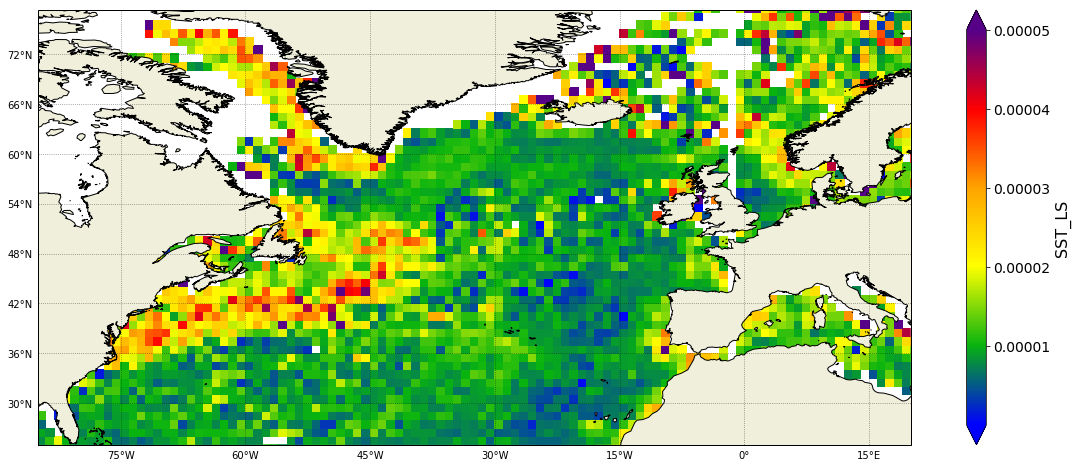

In [28]:
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_temperature_gradients['SST_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=5e-5)

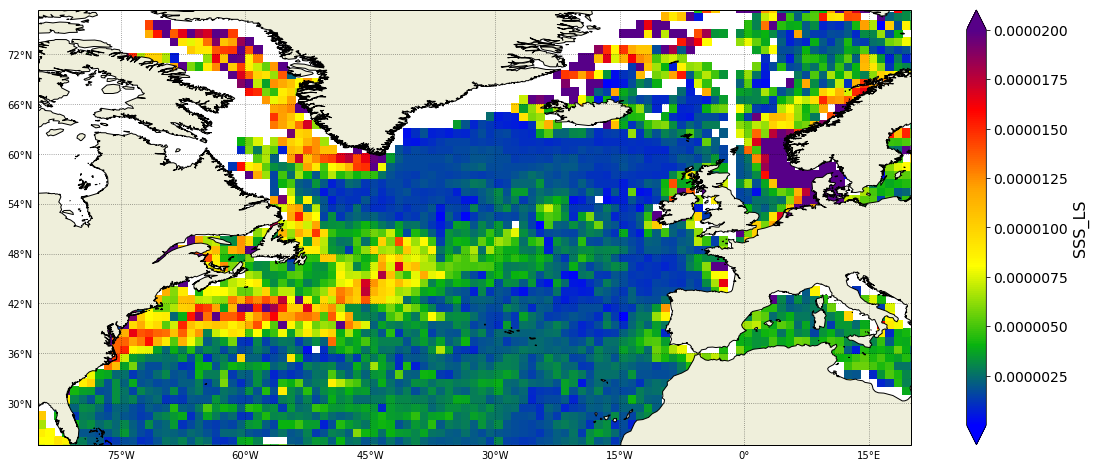

In [34]:
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_salinity_gradients['SSS_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=2e-5)

## Figure 2: Winter months (January, February, March)

In [36]:
ds_JFM = xr.open_dataset(path + 'GLOBAL/ALL_horizontal_gradients_JFM.nc', chunks={'time': 1e7})

### Figure 2a: Winter buoyancy gradients

In [38]:
binned_buoyancy_gradients = binning_gradients(np.abs(ds_JFM['SSb' + '_LS']), lon_res=1, lat_res=1)
binned_buoyancy_gradients.to_netcdf(path + 'GLOBAL/ALL_buoyancy_gradients_1x1_JFM.nc')

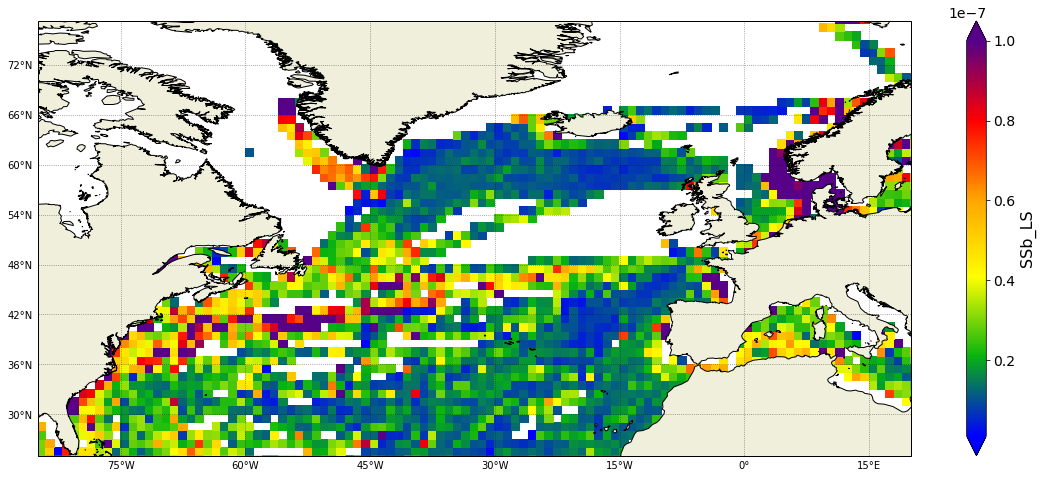

In [49]:
binned_buoyancy_gradients = xr.open_dataset(path + 'GLOBAL/ALL_buoyancy_gradients_1x1_JFM.nc')
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_buoyancy_gradients['SSb_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=1e-7)
plt.savefig('./Fig_2a-NATL_TSG_buoyancy_gradients_JFM_1x1.png', dpi=300, bbox_inches='tight')

### Figure 2b: Winter temperature gradients

In [41]:
binned_temperature_gradients = binning_gradients(np.abs(ds_JFM['SST' + '_LS']), lon_res=1, lat_res=1)
binned_temperature_gradients.to_netcdf(path + 'GLOBAL/ALL_temperature_gradients_1x1_JFM.nc')

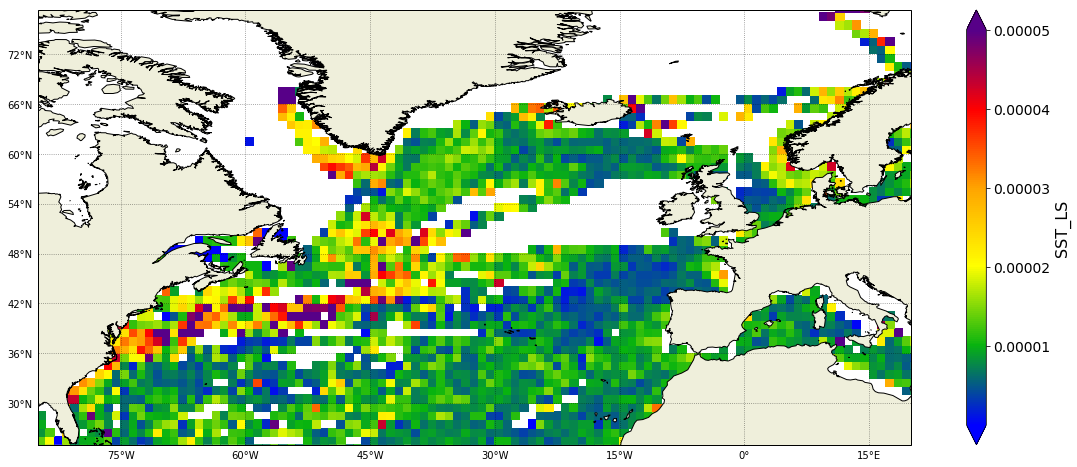

In [80]:
binned_temperature_gradients = xr.open_dataset(path + 'GLOBAL/ALL_temperature_gradients_1x1_JFM.nc')
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_temperature_gradients['SST_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=5e-5)
plt.savefig('./Fig_2b-NATL_TSG_temperature_gradients_JFM_1x1.png', dpi=300, bbox_inches='tight')

### Figure 2c: Winter salinity gradients

In [46]:
binned_salinity_gradients = binning_gradients(np.abs(ds_JFM['SSS' + '_LS']), lon_res=1, lat_res=1)
binned_salinity_gradients.to_netcdf(path + 'GLOBAL/ALL_salinity_gradients_1x1_JFM.nc')

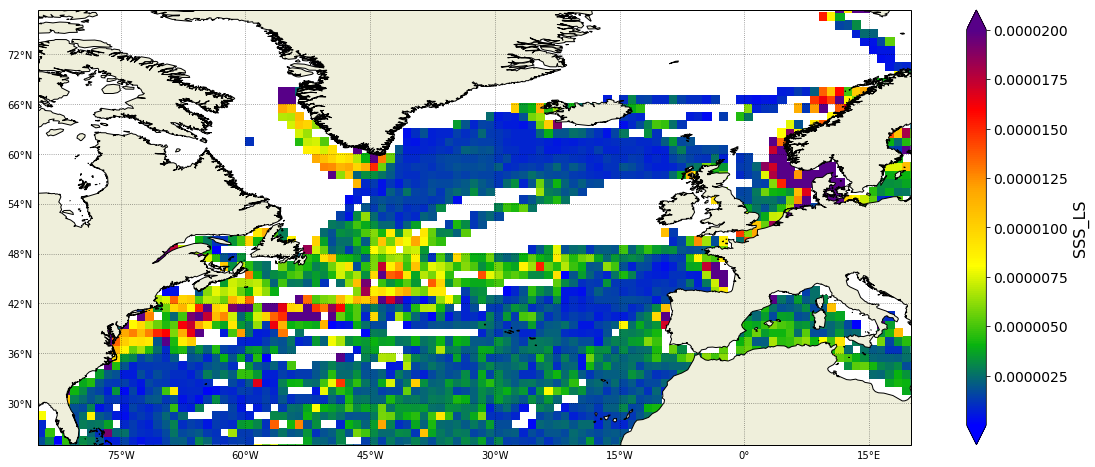

In [79]:
binned_salinity_gradients = xr.open_dataset(path + 'GLOBAL/ALL_salinity_gradients_1x1_JFM.nc')
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_salinity_gradients['SSS_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=2e-5)
plt.savefig('./Fig_2c-NATL_TSG_salinity_gradients_JFM_1x1.png', dpi=300, bbox_inches='tight')

### Combine figures with Imagemagick

In [82]:
%%system
montage Fig_2a* Fig_2b* Fig_2c* -geometry 3072x1024 -tile 1x3 -quality 100 Fig_2-NATL_TSG_tracer_gradients_JFM_1x1.png
convert Fig_2-NATL_TSG_tracer_gradients_JFM_1x1.png -trim -bordercolor White -border 20x10 +repage Fig_2-NATL_TSG_tracer_gradients_JFM_1x1.png

[]

## Figure 3: Summer months (July, August, September)

In [55]:
ds_JAS = xr.open_dataset(path + 'GLOBAL/ALL_horizontal_gradients_JAS.nc', chunks={'time': 1e7})

### Figure 3a: Summer buoyancy gradients

In [62]:
binned_buoyancy_gradients = binning_gradients(np.abs(ds_JAS['SSb' + '_LS']), lon_res=1, lat_res=1)
binned_buoyancy_gradients.to_netcdf(path + 'GLOBAL/ALL_buoyancy_gradients_1x1_JAS.nc')

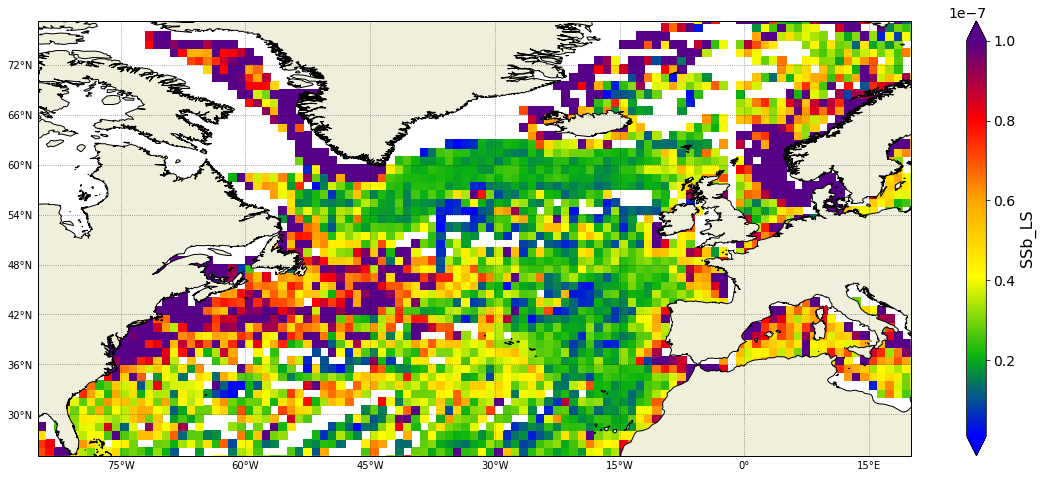

In [63]:
binned_buoyancy_gradients = xr.open_dataset(path + 'GLOBAL/ALL_buoyancy_gradients_1x1_JAS.nc')
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_buoyancy_gradients['SSb_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=1e-7)
plt.savefig('./Fig_3a-NATL_TSG_buoyancy_gradients_JAS_1x1.png', dpi=300, bbox_inches='tight')

### Figure 3b: Summer temperature gradients

In [65]:
binned_temperature_gradients = binning_gradients(np.abs(ds_JAS['SST' + '_LS']), lon_res=1, lat_res=1)
binned_temperature_gradients.to_netcdf(path + 'GLOBAL/ALL_temperature_gradients_1x1_JAS.nc')

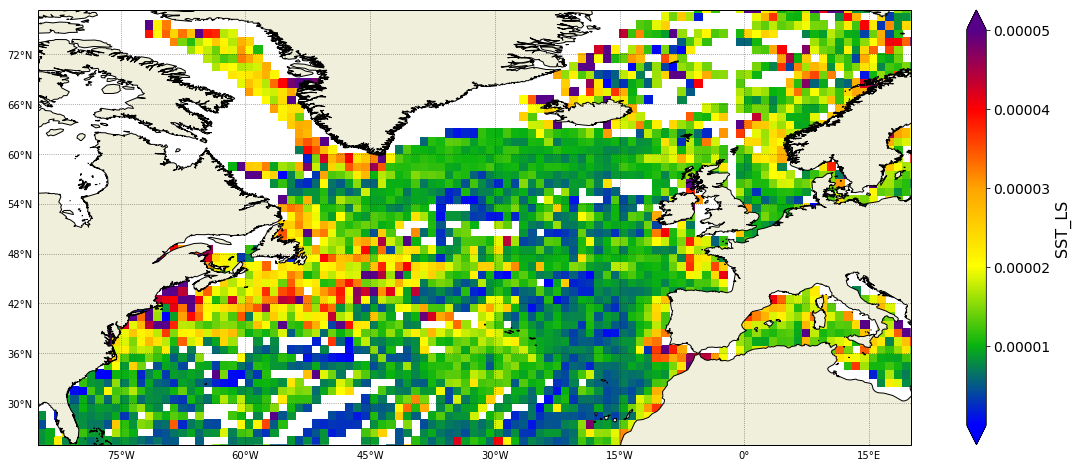

In [77]:
binned_temperature_gradients = xr.open_dataset(path + 'GLOBAL/ALL_temperature_gradients_1x1_JAS.nc')
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_temperature_gradients['SST_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=5e-5)
plt.savefig('./Fig_3b-NATL_TSG_temperature_gradients_JAS_1x1.png', dpi=300, bbox_inches='tight')

### Figure 3c: Summer salinity gradients

In [67]:
binned_salinity_gradients = binning_gradients(np.abs(ds_JAS['SSS' + '_LS']), lon_res=1, lat_res=1)
binned_salinity_gradients.to_netcdf(path + 'GLOBAL/ALL_salinity_gradients_1x1_JAS.nc')

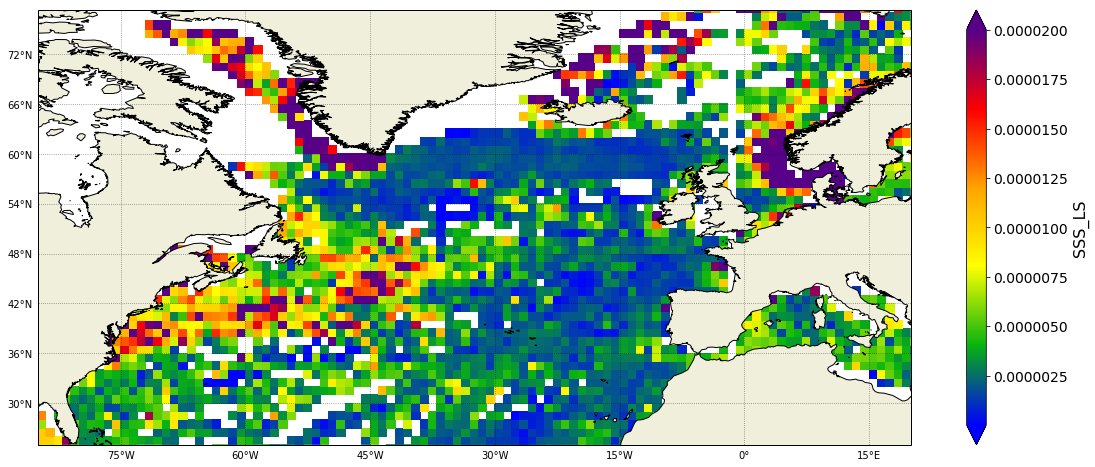

In [76]:
binned_salinity_gradients = xr.open_dataset(path + 'GLOBAL/ALL_salinity_gradients_1x1_JAS.nc')
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
binned_salinity_gradients['SSS_LS'].plot.pcolormesh(cmap=cmclimate.cm.BlGrYeOrReVi200, vmin=1e-9, vmax=2e-5)
plt.savefig('./Fig_3c-NATL_TSG_salinity_gradients_JAS_1x1.png', dpi=300, bbox_inches='tight')

### Combine figures with Imagemagick

In [83]:
%%system
montage Fig_3a* Fig_3b* Fig_3c* -geometry 3072x1024 -tile 1x3 -quality 100 Fig_3-NATL_TSG_tracer_gradients_JAS_1x1.png
convert Fig_3-NATL_TSG_tracer_gradients_JAS_1x1.png -trim -bordercolor White -border 20x10 +repage Fig_3-NATL_TSG_tracer_gradients_JAS_1x1.png

[]

# NATL60 estimate of surface buoyancy gradients

In [4]:
ds_nemo = xr.open_mfdataset("/data/NATL60/NATL60-CJM165_y201?m*.1d_hgradb_large_scale_coarse.nc")

In [5]:
nemo_buoyancy_gradients = ds_nemo['hgradb_large_scale']\
                                 .assign_coords(longitude=ds_nemo['longitude'].mean('time_counter'), 
                                                latitude=ds_nemo['latitude'].mean('time_counter'))

In [14]:
nemo_buoyancy_gradients['time_counter'] = pd.to_datetime(nemo_buoyancy_gradients['time_counter'])

In [33]:
nemo_by_month = dict(nemo_buoyancy_gradients.groupby('time_counter.month'))
nemo_buoyancy_gradients_JFM = xr.concat((nemo_by_month[1], nemo_by_month[2], nemo_by_month[3]), dim='time_counter')

### Annual mean of ME buoyancy gradients

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


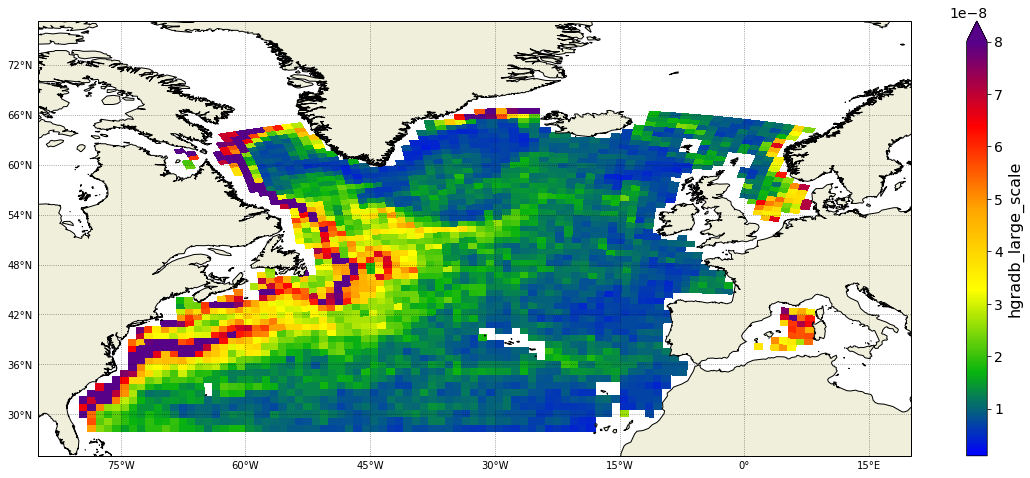

In [26]:
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
nemo_buoyancy_gradients.mean('time_counter').plot(x='longitude', y='latitude', vmin=1e-9, vmax=8e-8, cmap=cmclimate.cm.BlGrYeOrReVi200)

In [34]:
nemo_buoyancy_gradients_JFM

<xarray.DataArray 'hgradb_large_scale' (time_counter: 3, x: 57, y: 90)>
dask.array<shape=(3, 57, 90), dtype=float64, chunksize=(1, 57, 90)>
Coordinates:
    latitude      (x, y) float64 27.0 27.0 27.0 27.0 27.0 27.0 27.0 27.0 ...
    longitude     (x, y) float64 -80.96 -79.96 -78.96 -77.96 -76.96 -75.96 ...
  * time_counter  (time_counter) datetime64[ns] 2025-01-16T11:59:57.935483932 ...
Dimensions without coordinates: x, y
Attributes:
    units:      s^{-2}
    valid_min:  -1.0
    valid_max:  1.0
    long_name:  Large Scale Horizontal gradient of buoyancy

### Winter mean of ME buoyancy gradients

/home/serazin/anaconda2/envs/oceanscience/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


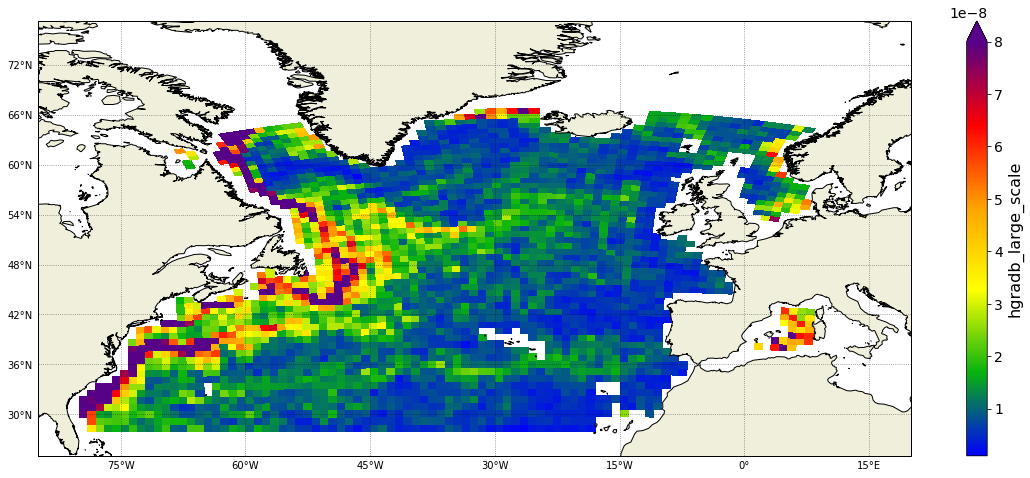

In [35]:
add_map(lon_min=-85, lon_max=20, lat_min=25, lat_max=70, scale='low')
nemo_buoyancy_gradients_JFM.mean('time_counter').plot(x='longitude', y='latitude', vmin=1e-9, vmax=8e-8, cmap=cmclimate.cm.BlGrYeOrReVi200)

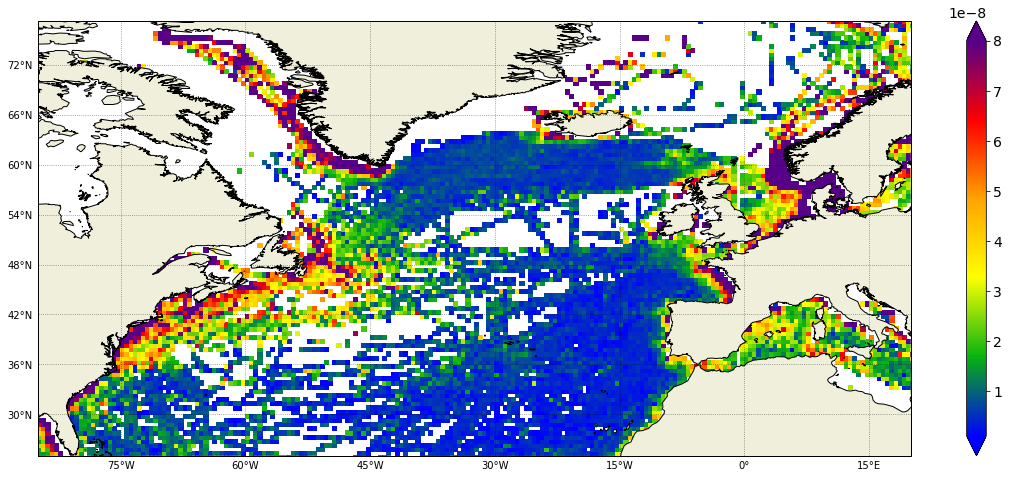

In [105]:
plot_and_bin_gradients(ds_ALL, lon_min=-85, lon_max=20, lat_min=25, lat_max=70)

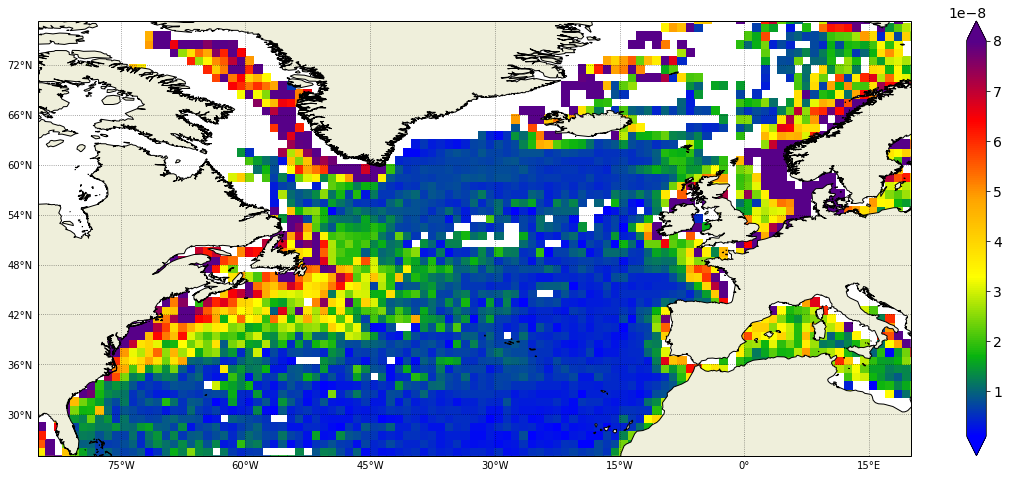

In [107]:
plot_and_bin_gradients(ds_ALL, lon_min=-85, lon_max=20, lat_min=25, lat_max=70)